In [1]:
protein = 'TTR'
subset = ['merge']
file_cutoff = 5.5
exclusion = 3

#### Functions definition

In [6]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations

native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

def prepare_pairs_list(protein, subset, file_cutoff, exclusion):
    # Create the DataFrame of the pairs list
    pairs_list = pd.read_csv(f'FF_greta_analysis_{protein}/{protein}_{subset}_magros.txt', sep='\\s+', index_col=False)

    pairs_list.insert(1, 'ai_resnumber', '')
    pairs_list.insert(1, 'ai_resname', '')
    pairs_list.insert(4, 'aj_resnumber', '')
    pairs_list.insert(4, 'aj_resname', '')

    # Separation of the atomtype and the aminoacid number. 
    # The atomtype column will be replaced avoiding to create a column and delete this one.
    pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
    pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
    # Replacing the atomtype values with aminoacid number as int
    pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
    pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
    # Conversion from str to int
    pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
    pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
    # Replacing the aminoacid number with the aminoacid name
    pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
    pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

    #print(pairs_list)#.to_string())
    return pairs_list


def pairs_extraction(pairs_list, contacts_histogram, sigma_histogram, pdb_resids):
    # Function to extract the informations from the pairs list
    for an in pdb_resids:
        # pdb_resids is the aminocid numbers
        # Selection of the rows contaning the aminoacid number of interest.
        # Note the | and not the &
        is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

        # Filtering a dataframe containing only the aminoacid selected.
        pairs_an = pairs_list[is_an]
        #print(pairs_an.to_string())

        print(f'\nTotal amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
        pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
        pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)
        #print(pairs_an.to_string())
        
        # Create Pandas Series with contact counts for every aminoacid in an selection:
        # an_with_who count of the unique values in column "an_with_who" in pairs_an dataframe
        an_with_who = pairs_an.an_with_who.value_counts()
        print(f'\nList of contacts based on aminoacid:\n{an_with_who.to_string()}')

        # Change "an_with_who" in a dictionary to put in a matrix
        contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
        #print(f'\nAnd the consequent nested dictionary:\n{contacts_histogram}\n')


        # Matrix Sigma creation
        set_an_with_who = set(pairs_an["an_with_who"])

        
    
    return contacts_histogram


def make_contacts_histo_df(contacts_histogram):
    # Contact dataframe preparation
    histo_df = pd.DataFrame(contacts_histogram)
    histo_df[''] = histo_df.index.astype(str)
    histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
    histo_df.sort_values(by = [''], inplace = True)
    histo_df.drop(columns='', inplace=True)
    histo_df = histo_df.fillna(0)
    histo_df.columns = list(amino_dict_num.values())
    print(histo_df.to_string())
    return histo_df

/home/emanuele/anaconda2/envs/py37/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:330: UserWarning: Element information is absent or missing for a few atoms. Elements attributes will not be populated.
  warnings.warn("Element information is absent or missing for a few "
/home/emanuele/anaconda2/envs/py37/lib/python3.7/site-packages/MDAnalysis/core/topologyattrs.py:2261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


#### Start

In [9]:
#native_pairs = prepare_pairs_list(protein, subset[0], file_cutoff, exclusion)
#fibril_pairs = prepare_pairs_list(protein, subset[1], file_cutoff, exclusion)
merge_pairs = prepare_pairs_list(protein, subset[0], file_cutoff, exclusion)

#native_contacts_histogram = {}
#fibril_contacts_histogram = {}
merge_contacts_histogram = {}

#native_sigma_histogram = {}
#fibril_sigma_histogram = {}
merge_sigma_histogram = {}

#native_contacts_histogram, native_sigma_histogram = pairs_extraction(native_pairs, native_contacts_histogram, native_sigma_histogram, pdb_resids)
#fibril_contacts_histogram, fibril_sigma_histogram = pairs_extraction(fibril_pairs, fibril_contacts_histogram, fibril_sigma_histogram, pdb_resids)
merge_contacts_histogram = pairs_extraction(merge_pairs, merge_contacts_histogram, merge_sigma_histogram, pdb_resids)

#native_contacts = make_contacts_histo_df(native_contacts_histogram)
#fibril_contacts = make_contacts_histo_df(fibril_contacts_histogram)
merge_contacts = make_contacts_histo_df(merge_contacts_histogram)


Total amount of contacts made by TYR_1: 257

List of contacts based on aminoacid:
SER_11    77
TYR_10    71
TYR_1     69
THR_2     36
ILE_3      4

Total amount of contacts made by THR_2: 169

List of contacts based on aminoacid:
TYR_1     36
TYR_10    35
THR_2     28
PRO_9     26
ILE_3     23
SER_11    21

Total amount of contacts made by ILE_3: 156

List of contacts based on aminoacid:
ILE_3     33
ALA_4     29
TYR_10    25
THR_2     23
SER_8     18
PRO_9     17
ALA_5      5
TYR_1      4
LEU_7      1
LEU_6      1

Total amount of contacts made by ALA_4: 103

List of contacts based on aminoacid:
ILE_3    29
LEU_7    20
PRO_9    18
ALA_5    16
ALA_4    15
SER_8     3
LEU_6     2

Total amount of contacts made by ALA_5: 84

List of contacts based on aminoacid:
LEU_6    32
ALA_4    16
ALA_5    15
LEU_7    15
ILE_3     5
SER_8     1

Total amount of contacts made by LEU_6: 133

List of contacts based on aminoacid:
LEU_7     49
LEU_6     36
ALA_5     32
SER_8      9
SER_11     4
ALA_4    

Text(0.5, 1.07, 'Cutoff 5.5, ex 3')

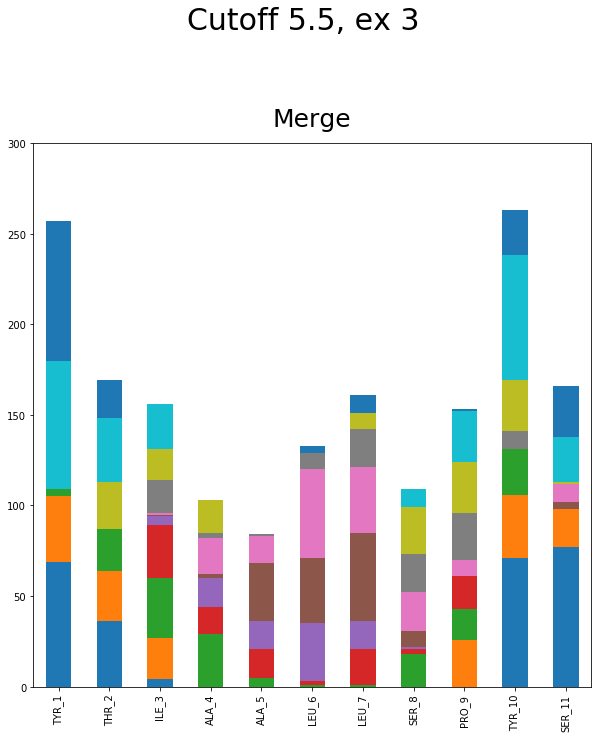

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

figure, ax3 = plt.subplots(1, 1, figsize = (10,10))
#ax1 = native_contacts.plot(ax=ax1, kind = "bar", stacked = True)
#ax1.set_title('Native', fontsize = 25, y = 1.02)
#ax1.get_legend().remove()
#ax1.set_ylim(0, 300)

#ax2 = fibril_contacts.plot(ax=ax2, kind = "bar", stacked = True)
#ax2.set_title('Fibril', fontsize = 25, y = 1.02)
#ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
#ax2.set_ylim(0, 300)

ax3 = merge_contacts.plot(ax=ax3, kind = "bar", stacked = True)
ax3.set_title('Merge', fontsize = 25, y = 1.02)
ax3.get_legend().remove()
ax3.set_ylim(0, 300)

figure.suptitle(f'Cutoff {file_cutoff}, ex {exclusion}', fontsize = 30, y = 1.07)


Text(0.5, 1.07, 'Cutoff 5.5, ex 3')

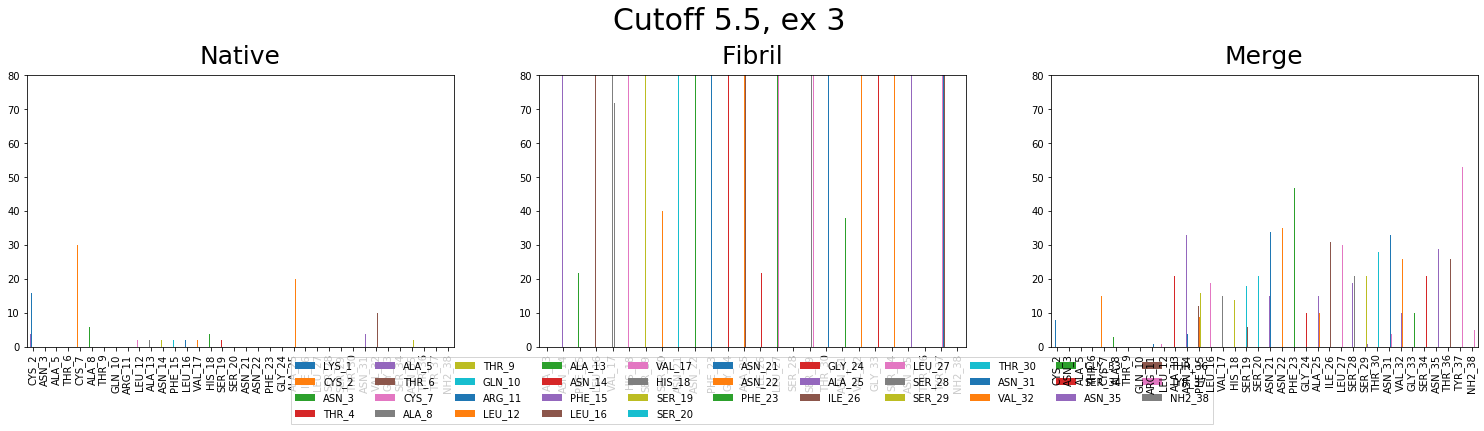

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (26,5))
ax1 = native_contacts.plot(ax=ax1, kind = "bar", stacked = False)
ax1.set_title('Native', fontsize = 25, y = 1.02)
ax1.get_legend().remove()
ax1.set_ylim(0, 80)

ax2 = fibril_contacts.plot(ax=ax2, kind = "bar", stacked = False)
ax2.set_title('Fibril', fontsize = 25, y = 1.02)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
ax2.set_ylim(0, 80)

ax3 = merge_contacts.plot(ax=ax3, kind = "bar", stacked = False)
ax3.set_title('Merge', fontsize = 25, y = 1.02)
ax3.get_legend().remove()
ax3.set_ylim(0, 80)

figure.suptitle(f'Cutoff {file_cutoff}, ex {exclusion}', fontsize = 30, y = 1.07)


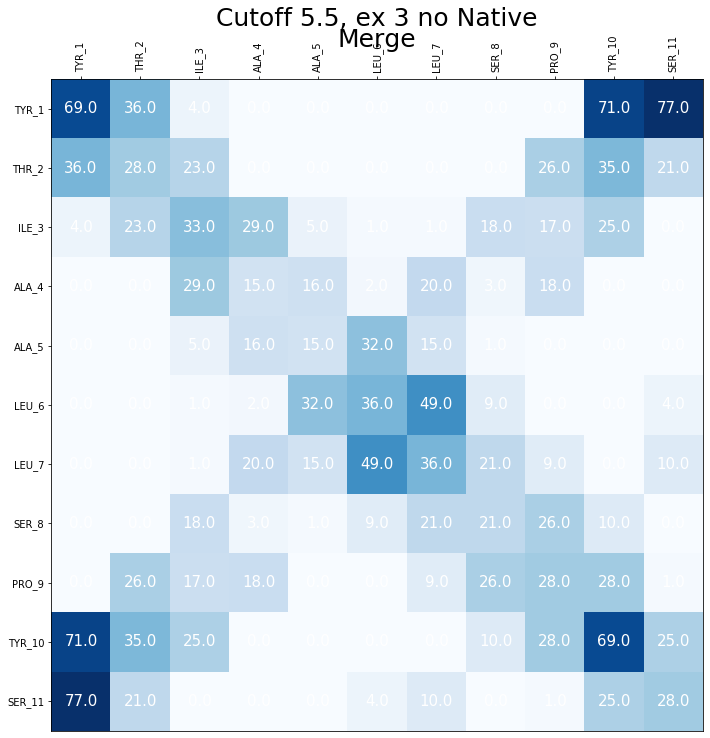

In [12]:
import numpy as np


# NATIVE
fig, ax3 = plt.subplots(1, 1, figsize = (30,10))



# MERGE
merge_matrix = merge_contacts.to_numpy()
ax3.imshow(merge_matrix, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax3.set_xticks(np.arange(len(merge_contacts.columns)))
ax3.set_yticks(np.arange(len(merge_contacts.index)))
# Naming all the axis values
ax3.set_xticklabels(list(merge_contacts.columns))
ax3.set_yticklabels(list(merge_contacts.index))
# Rotate x labels
ax3.xaxis.tick_top()
ax3.set_title('Merge', fontsize = 25, y = 1.04)
plt.setp(ax3.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(merge_contacts.index)):
    for j in range(len(merge_contacts.columns)):
        text = ax3.text(j,i, merge_matrix[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.suptitle(f'Cutoff {file_cutoff}, ex {exclusion} no Native', fontsize = 25, y = 1.02)
fig.tight_layout()

In [13]:
# Making a normalized dataframe and matrix
pd.options.display.float_format = '{:.2f}'.format


merge_contacts_norm = merge_contacts.div(merge_contacts.max().max())
print(merge_contacts_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    0.90   0.47   0.05   0.00   0.00   0.00   0.00   0.00   0.00    0.92    1.00
THR_2    0.47   0.36   0.30   0.00   0.00   0.00   0.00   0.00   0.34    0.45    0.27
ILE_3    0.05   0.30   0.43   0.38   0.06   0.01   0.01   0.23   0.22    0.32    0.00
ALA_4    0.00   0.00   0.38   0.19   0.21   0.03   0.26   0.04   0.23    0.00    0.00
ALA_5    0.00   0.00   0.06   0.21   0.19   0.42   0.19   0.01   0.00    0.00    0.00
LEU_6    0.00   0.00   0.01   0.03   0.42   0.47   0.64   0.12   0.00    0.00    0.05
LEU_7    0.00   0.00   0.01   0.26   0.19   0.64   0.47   0.27   0.12    0.00    0.13
SER_8    0.00   0.00   0.23   0.04   0.01   0.12   0.27   0.27   0.34    0.13    0.00
PRO_9    0.00   0.34   0.22   0.23   0.00   0.00   0.12   0.34   0.36    0.36    0.01
TYR_10   0.92   0.45   0.32   0.00   0.00   0.00   0.00   0.13   0.36    0.90    0.32
SER_11   1.00   0.27   0.00   0.00   0.00   0.05   0.1

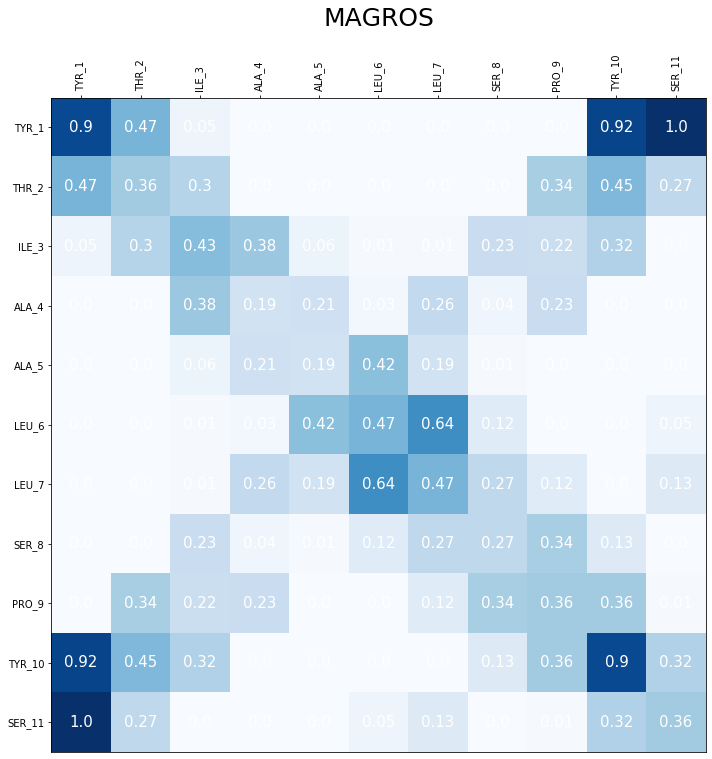

In [17]:


merge_matrix_norm = merge_contacts_norm.to_numpy()
merge_matrix_norm = merge_matrix_norm.round(decimals = 2)

# NATIVE
fig,  ax3 = plt.subplots(1,1, figsize = (10,15))


# MERGE
ax3.imshow(merge_matrix_norm, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax3.set_xticks(np.arange(len(merge_contacts_norm.columns)))
ax3.set_yticks(np.arange(len(merge_contacts_norm.index)))
# Naming all the axis values
ax3.set_xticklabels(list(merge_contacts_norm.columns))
ax3.set_yticklabels(list(merge_contacts_norm.index))
# Rotate x labels
ax3.xaxis.tick_top()
#ax3.set_title('Merge', fontsize = 25, y = 1.04)
plt.setp(ax3.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')
ax3.set_title(f'MAGROS', fontsize = 25, y = 1.1)

# Loop over data dimensions and create tet annotations
for i in range(len(merge_contacts_norm.index)):
    for j in range(len(merge_contacts_norm.columns)):
        text = ax3.text(j,i, merge_matrix_norm[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()

fig.savefig(f'coso.png', dpi= 800)

In [9]:
# Sigmas dataframe preparation
pd.options.display.float_format = '{:,.5f}'.format
native_histo_sigma = pd.DataFrame(native_sigma_histogram)
native_histo_sigma = native_histo_sigma.apply(pd.to_numeric)
native_histo_sigma[''] = native_histo_sigma.index.astype(str)
native_histo_sigma[''] = native_histo_sigma[''].str.split('_').str[1].astype(int)
native_histo_sigma.sort_values(by = [''], inplace = True)
native_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
native_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())

fibril_histo_sigma = pd.DataFrame(fibril_sigma_histogram)
fibril_histo_sigma = fibril_histo_sigma.apply(pd.to_numeric)
fibril_histo_sigma[''] = fibril_histo_sigma.index.astype(str)
fibril_histo_sigma[''] = fibril_histo_sigma[''].str.split('_').str[1].astype(int)
fibril_histo_sigma.sort_values(by = [''], inplace = True)
fibril_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
fibril_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())

merge_histo_sigma = pd.DataFrame(merge_sigma_histogram)
merge_histo_sigma = merge_histo_sigma.apply(pd.to_numeric)
merge_histo_sigma[''] = merge_histo_sigma.index.astype(str)
merge_histo_sigma[''] = merge_histo_sigma[''].str.split('_').str[1].astype(int)
merge_histo_sigma.sort_values(by = [''], inplace = True)
merge_histo_sigma.drop(columns='', inplace=True)
#histo_sigma = histo_sigma.fillna(0)
native_histo_sigma.columns = list(amino_dict_num.values())
print(native_histo_sigma.to_string())


        LYS_1   CYS_2   ASN_3  THR_4   ALA_5   THR_6   CYS_7   ALA_8   THR_9  GLN_10  ARG_11  LEU_12  ALA_13  ASN_14  PHE_15  LEU_16  VAL_17  HIS_18  SER_19  SER_20  ASN_21  ASN_22  PHE_23  GLY_24  ALA_25  ILE_26  LEU_27  SER_28  SER_29  THR_30  ASN_31  VAL_32  GLY_33  SER_34  ASN_35  THR_36  TYR_37  NH2_38
CYS_2     nan     nan     nan    nan 0.45546     nan 0.38480     nan     nan     nan 0.40081     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan
ASN_3     nan     nan     nan    nan     nan     nan     nan 0.45827     nan     nan 0.41774     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan
ALA_5     nan 0.45546     nan    nan     nan     nan     nan 0.38676 0.44

0.37418
0.38037
0.37418


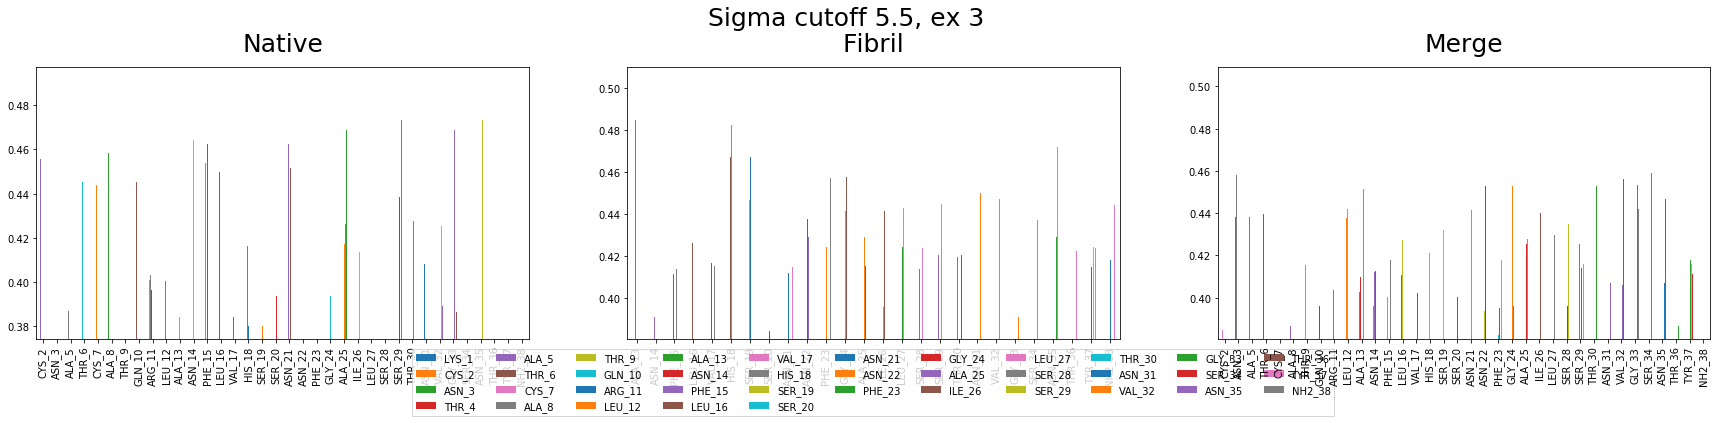

In [10]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (90,10))
ax1 = native_histo_sigma.plot(ax = ax1, kind = "bar", stacked = False, figsize = (30,5))
ax1.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax1.set_ylim(bottom=(native_histo_sigma.min()).min())
ax1.set_title('Native', fontsize = 25, y = 1.04)
ax1.get_legend().remove()
print((native_histo_sigma.min()).min())

ax2 = fibril_histo_sigma.plot(ax = ax2, kind = "bar", stacked = False, figsize = (30,5))
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax2.set_ylim(bottom=(fibril_histo_sigma.min()).min())
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
print((fibril_histo_sigma.min()).min())

ax3 = merge_histo_sigma.plot(ax=ax3, kind = "bar", stacked = False, figsize = (30,5))
ax3.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax3.set_ylim(bottom=(fibril_histo_sigma.min()).min())
ax3.set_title('Merge', fontsize = 25, y = 1.04)
fig.suptitle(f'Sigma cutoff {all_plots_{cdt}file_cutoff}, ex {exclusion}', fontsize = 25, y = 1.05)
ax3.get_legend().remove()
print((merge_histo_sigma.min()).min())

In [11]:
# Distance dataframe preparation

native_histo_distance = native_histo_sigma.apply(lambda a: a*(2**(1/6)))
native_histo_distance[''] = native_histo_distance.index.astype(str)
native_histo_distance[''] = native_histo_distance[''].str.split('_').str[1].astype(int)
native_histo_distance.sort_values(by = [''], inplace = True)
native_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
native_histo_distance.columns = list(amino_dict_num.values())
print(native_histo_distance.to_string())

fibril_histo_distance = fibril_histo_sigma.apply(lambda a: a*(2**(1/6)))
fibril_histo_distance[''] = fibril_histo_distance.index.astype(str)
fibril_histo_distance[''] = fibril_histo_distance[''].str.split('_').str[1].astype(int)
fibril_histo_distance.sort_values(by = [''], inplace = True)
fibril_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
fibril_histo_distance.columns = list(amino_dict_num.values())
print(fibril_histo_distance.to_string())

merge_histo_distance = merge_histo_sigma.apply(lambda a: a*(2**(1/6)))
merge_histo_distance[''] = merge_histo_distance.index.astype(str)
merge_histo_distance[''] = merge_histo_distance[''].str.split('_').str[1].astype(int)
merge_histo_distance.sort_values(by = [''], inplace = True)
merge_histo_distance.drop(columns='', inplace=True)
#histo_distance = histo_distance.fillna(0)
merge_histo_distance.columns = list(amino_dict_num.values())
print(merge_histo_distance.to_string())

        LYS_1   CYS_2   ASN_3  THR_4   ALA_5   THR_6   CYS_7   ALA_8   THR_9  GLN_10  ARG_11  LEU_12  ALA_13  ASN_14  PHE_15  LEU_16  VAL_17  HIS_18  SER_19  SER_20  ASN_21  ASN_22  PHE_23  GLY_24  ALA_25  ILE_26  LEU_27  SER_28  SER_29  THR_30  ASN_31  VAL_32  GLY_33  SER_34  ASN_35  THR_36  TYR_37  NH2_38
CYS_2     nan     nan     nan    nan 0.51124     nan 0.43192     nan     nan     nan 0.44989     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan
ASN_3     nan     nan     nan    nan     nan     nan     nan 0.51439     nan     nan 0.46890     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan     nan
ALA_5     nan 0.51124     nan    nan     nan     nan     nan 0.43412 0.49

0.4200028492364012
0.4269508893154362
0.4200028492364012


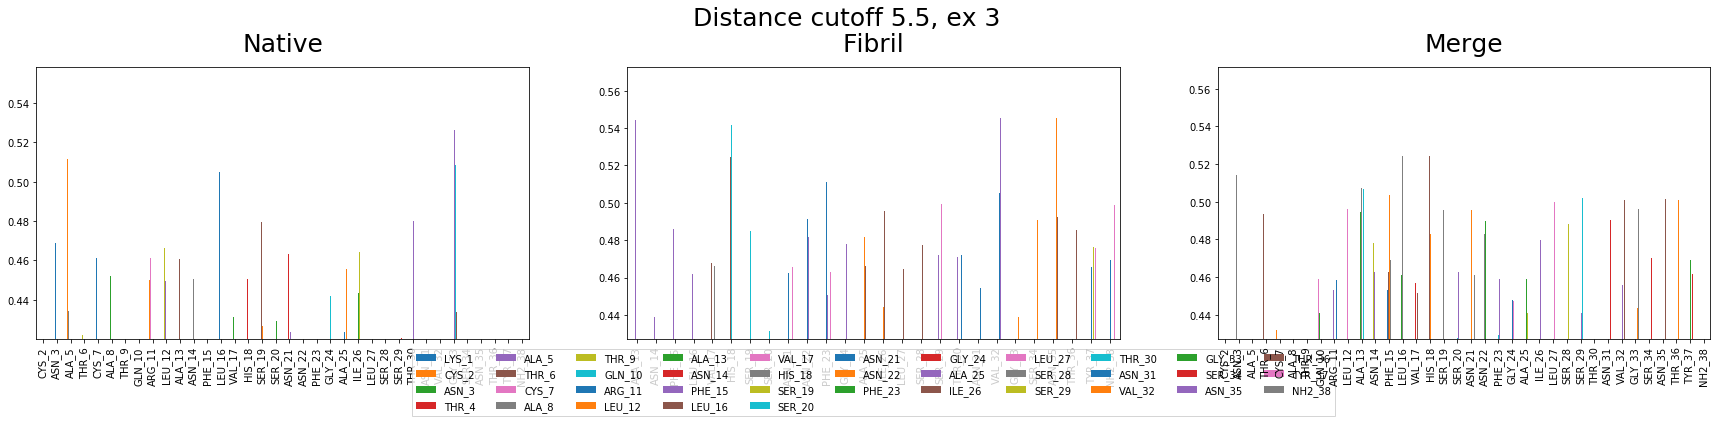

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (90,10))
ax1 = native_histo_distance.plot(ax = ax1, kind = "bar", stacked = False, figsize = (30,5))
ax1.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax1.set_ylim(bottom=(native_histo_distance.min()).min())
ax1.set_title('Native', fontsize = 25, y = 1.04)
ax1.get_legend().remove()
print((native_histo_distance.min()).min())

ax2 = fibril_histo_distance.plot(ax = ax2, kind = "bar", stacked = False, figsize = (30,5))
ax2.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax2.set_ylim(bottom=(fibril_histo_distance.min()).min())
ax2.set_title('Fibril', fontsize = 25, y = 1.04)
ax2.legend(loc = 'lower center', ncol = 11, bbox_to_anchor = (0.5, -0.3), fancybox = False)
print((fibril_histo_distance.min()).min())

ax3 = merge_histo_distance.plot(ax=ax3, kind = "bar", stacked = False, figsize = (30,5))
ax3.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
ax3.set_ylim(bottom=(fibril_histo_distance.min()).min())
ax3.set_title('Merge', fontsize = 25, y = 1.04)
fig.suptitle(f'Distance cutoff {file_cutoff}, ex {exclusion}', fontsize = 25, y = 1.05)
ax3.get_legend().remove()
print((merge_histo_distance.min()).min())